In [2]:
# ! python.exe -m pip install --upgrade pip
# ! pip install numpy
# ! pip install torch
# ! pip install tqdm
# ! pip install ipywidgets --upgrade
# ! pip install jupyter
# ! pip install --upgrade notebook jupyterlab ipywidgets
import numpy as np
print(np.__version__)
import math
import random

import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

from tqdm.notebook import trange

2.2.2
2.6.0+cpu


In [3]:
class ConnectFour:
    def __init__(self):
        self.row_count = 6
        self.column_count = 7
        self.action_size = self.column_count

    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))

    def get_next_state(self, state, action: int, player):
        for row in reversed(range(self.row_count)):
            if state[row, action] == 0:
                state[row, action] = player
                return state

        # should not happen
        return state

    def get_valid_moves(self, state):
        return (state[0] == 0).astype(np.uint8)

    def check_win(self, state, action): 
        if action == None: return False
        # Get player
        for row in range(self.row_count):
            if state[row][action] != 0:
                player = state[row][action]
                break
        for row in range(self.row_count):
            for col in range(self.column_count):
                if self.check_direction(row, col, 1, 0, player, state) or \
                   self.check_direction(row, col, 0, 1, player, state) or \
                   self.check_direction(row, col, 1, 1, player, state) or \
                   self.check_direction(row, col, 1, -1, player, state):
                    return True

    def check_direction(self, row, col, drow, dcol, player, state):
        count = 0
        for _ in range(4):
            if 0 <= row < self.row_count and 0 <= col < self.column_count and state[row][col] == player:
                count += 1
                if count >= 4:
                    return True
            else:
                break
            row += drow
            col += dcol
        return False

    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False

    def get_opponent(self, player):
        return -player

    def get_opponent_value(self, value):
        return -value

    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        # Encode it for the AI
        # Look at the architecture notes in docs
        # We want three input states, one for each player and one with empty cells
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)

        return encoded_state
    
    def print_state(self, state):
        symbols = {0: "-", 1: "X", -1: "O"}
        display = "\n".join(" ".join(symbols[cell] for cell in row) for row in state)
        print(display)
        
        

In [ ]:
# Start by creating our game, which AlphaZero will play.
class TicTacToe:
    def __init__(self):
        self.row_count = 3
        self.column_count = 3
        # action size is the amount of possible actions (moves)
        self.action_size = self.row_count * self.column_count

    def get_initial_state(self):
        # new board = board full of zeros
        return np.zeros((self.column_count, self.row_count))

    def get_next_state(self, state, action: int, player):
        """
        state = board (2D array)
        action = 0-8 which cell to place move
        player = player
        """
        row = action // self.column_count
        column = action % self.column_count
        state[row, column] = player
        return state

    def get_valid_moves(self, state):
        # state.reshape() reshapes the matrix, in our case from 3x3 into something else
        # the -1 in state.reshape(-1) tells np to reshape automatically
        # in our case our 3x3 will become 1x9, the output is the new np matrix
        # looking like this: ([0, 0, 0, 0, 0, 0, 0, 0, 0])
        # by doing == 0 we get an output array like this:
        # np.array([True, True, True, True, True, True, True, True, True])
        # the last code, astype, tells np to convert the values into unsigned integers, making the array:
        # np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])
        return (state.reshape(-1) == 0).astype(np.uint8)

    def check_win(self, state, action):
        if action == None:
            return False
            
        row = action // self.column_count
        column = action % self.column_count
        player = state[row, column]

        return (
            # Checks for rows, assume player is an integer
            np.sum(state[row, :]) == player * self.column_count
            or np.sum(state[:, column]) == player * self.row_count
            # Checks for diagonals, 
            or np.sum(np.diag(state)) == player * self.row_count
            or np.sum(np.diag(np.flip(state, axis=0))) == player * self.row_count
        )

    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False

    def get_opponent(self, player):
        return -player

    def get_opponent_value(self, value):
        return -value

    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        # Encode it for the AI
        # Look at the architecture notes in docs
        # We want three input states, one for each player and one with empty cells
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)

        return encoded_state

    def print_state(self, state):
        symbols = {0: "-", 1: "X", -1: "O"}
        display = "\n".join(" ".join(symbols[cell] for cell in row) for row in state)
        print(display)

In [ ]:
# normal MCTS

# Here, the node will never know of the player
# Instead, the rest of the code is programmed so that the state of the board
# will always be from the nodes perspective (i.e. flipped, or inverted might be a better word)
# For the node, the player is always player 1.
# Logic should be easier, and also valid for 1 player games
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        # probability by policy vector from parent, used in expansion 
        self.prior = prior

        self.children = []

        # Not needed with CNN, we expand all everytime
        # self.expandable_moves = game.get_valid_moves(state)

        self.visit_count = 0
        self.value_sum = 0

    def is_fully_expanded(self):
        # OLD, with CNN all will be expanded at once
        # return np.sum(self.expandable_moves) == 0 and len(self.children) > 0
        return len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * child.prior * (math.sqrt(self.visit_count)/(child.visit_count + 1))

    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)

                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)

    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1

        # flip player
        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)
        

class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model

    # decorator as we don't want to store gradients
    # don't know why
    @torch.no_grad()
    def search(self, state):
        # define root 
        root = Node(self.game, self.args, state)
        for search in range(self.args['num_searches']):
            node = root
            # selection
            while node.is_fully_expanded():
                node = node.select()

            # The action taken here will be from the opponent,
            # Because of that, we take the negative value
            # That is, the value seen from our node
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)

            if not is_terminal:
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state)).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                # mask out invalid moves, 
                policy *= valid_moves
                # normalize, 
                policy /= np.sum(policy)

                # .item() on tensor with 1 float = you get the float
                # this value replaces the simulation part
                value = value.item()

                # expansion
                node.expand(policy)
            # backpropagation
            node.backpropagate(value)
        
        # return visit_counts
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        # Turn into probabilities, i.e. we want values in [0, 1].
        # In this MCTS, the node with the most amount of visits 
        # is deemed the most promising move
        action_probs /= np.sum(action_probs)
        return action_probs



In [ ]:
class AlphaZero:
  def __init__(self, model, optimizer, game, args):
    self.model = model
    self.optimizer = optimizer
    self.game = game
    self.args = args
    self.mcts = MCTS(game, args, model)

  def selfPlay(self):
    memory = []
    player = 1
    state = self.game.get_initial_state()

    while True: 
      # remember, we want to search from player 1 perspective
      neutral_state = self.game.change_perspective(state, player)
      action_probs = self.mcts.search(neutral_state)

      memory.append((neutral_state, action_probs, player))

      action = np.random.choice(self.game.action_size, p=action_probs)

      state = self.game.get_next_state(state, action, player)

      value, is_terminal = self.game.get_value_and_terminated(state, action)

      if is_terminal:
        returnMemory = []
        for hist_neutral_state, hist_action_probs, hist_player in memory:
          hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
          returnMemory.append((
            self.game.get_encoded_state(hist_neutral_state),
            hist_action_probs,
            hist_outcome
          ))
        return returnMemory
    
      player = self.game.get_opponent(player)

  def train(self, memory):
      random.shuffle(memory)
      for batchIdx in range(0, len(memory), self.args['batch_size']):
          sample = memory[batchIdx:min(len(memory)-1, batchIdx + self.args['batch_size'])]
          # Transpose sample 
          state, policy_targets, value_targets = zip(*sample)

          state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)

          state = torch.tensor(state, dtype=torch.float32)
          policy_targets = torch.tensor(policy_targets, dtype=torch.float32)
          value_targets = torch.tensor(value_targets, dtype=torch.float32)

          out_policy, out_value = self.model(state)

          policy_loss = F.cross_entropy(out_policy, policy_targets)
          value_loss = F.mse_loss(out_value, value_targets)
          loss = policy_loss + value_loss

          self.optimizer.zero_grad()
          loss.backward()
          optimizer.step()          

  def learn(self):
    for iteration in range(self.args['num_iterations']):
      memory = []

      self.model.eval()
      # trange = range() but with progress bars
      for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
        memory += self.selfPlay()

      self.model.train()
      for epoch in trange(self.args['num_epochs']):
        self.train(memory)

      torch.save(self.model.state_dict(), f"model_{iteration}.pt")
      torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")

In [5]:
class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden):
        super().__init__()
        self.startBlock = nn.Sequential(
            # we can use kernel = 3 because we use padding = 1, 
            # so image will still be 3x3 (if you want to look at it like an image)
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            # increase training speed
            nn.BatchNorm2d(num_hidden),
            # turn negatives to 0s, faster and safer to train
            nn.ReLU()
        )

        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )

        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            # this is the policy vector
            # it should output the size of possible moves
            # I think, why not just use len(game.get_valid_moves(state)), idk
            # jag kom på varför
            nn.Linear(32 * game.row_count * game.column_count, game.action_size)
        )

        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.column_count, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value


class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

In [ ]:
# AlphaZero testing

game = ConnectFour()

model = ResNet(game, 4, 64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
try:
    model.load_state_dict(torch.load('model_2.pt'))
except FileNotFoundError:
    print("Training from scratch")
    
args = {
  'C': 2,
  'num_searches': 80,
  'num_iterations': 8,
  'num_selfPlay_iterations': 500,
  'num_epochs': 4,
  'batch_size': 64
}

alphaZero = AlphaZero(model, optimizer, game, args)
alphaZero.learn()

-0.08199262619018555
[0.0074585  0.05518941 0.22101723 0.3334862  0.08377649 0.20687835
 0.09219384]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  0.]]
tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0.]],

         [[1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 0., 0., 1., 1., 1.]],

         [[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0

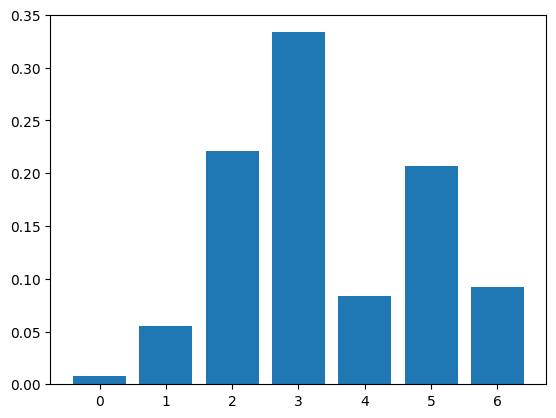

In [7]:
# CNN testing
# ! pip install matplotlib
import matplotlib.pyplot as plt

tictactoe = ConnectFour()

state = tictactoe.get_initial_state()
state = tictactoe.get_next_state(state, 2, 1)
state = tictactoe.get_next_state(state, 3, -1)

encoded_state = tictactoe.get_encoded_state(state)

# no clue vad tensor, array av arrays?
# typ för att representera en nod och deras inkommande weights
# Because one state, and not a batch, we need to unsqueeze (ingen aning)
tensor_state = torch.tensor(encoded_state).unsqueeze(0)

model = ResNet(tictactoe, 4, 64)
# Nu är den tränad, vamos
model.load_state_dict(torch.load('model_2.pt'))
model.eval()

policy, value = model(tensor_state)
value = value.item()
# ingen aning
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value)
print(policy)
print(state)
print(tensor_state)

plt.bar(range(tictactoe.action_size), policy)
plt.show()

- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
valid moves: [0, 1, 2, 3, 4, 5, 6]
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - X - - -
Thinking...


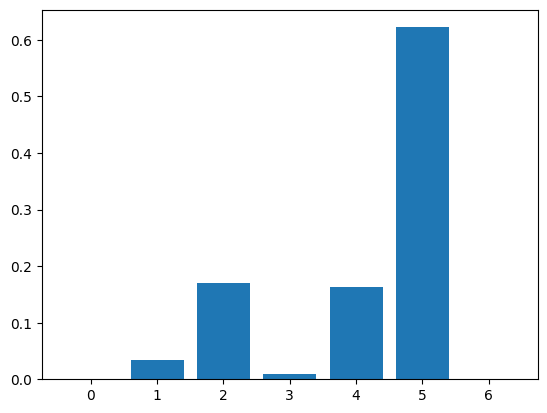

- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - X - O -
valid moves: [0, 1, 2, 3, 4, 5, 6]


ValueError: invalid literal for int() with base 10: ''

In [8]:
### CNN and MCTS

game = ConnectFour()
player = 1

args = {
    'C': 2,
    'num_searches': 4000
}

model = ResNet(game, 4, 64)
model.load_state_dict(torch.load('model_3.pt'))
model.eval()

mcts = MCTS(game, args, model)

state = game.get_initial_state()

while True:
    game.print_state(state)

    if player == 1:
        valid_moves = game.get_valid_moves(state)
        print("valid moves:", [i for i in range(game.action_size) if valid_moves[i] == 1])
        action = int(input(f"{player}:"))
    
        if valid_moves[action] == 0:
            print("action not valid")
            continue
    else:
        print("Thinking...")
        neutral_state = game.change_perspective(state, player)
        policy = mcts.search(state)
        # Utan MCTS, glömde av att man kör MCTS också
        # encoded_state = game.get_encoded_state(neutral_state)
        # tensor_state = torch.tensor(encoded_state).unsqueeze(0)
        # policy, _ = model(tensor_state)
        # policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()
        plt.bar(range(game.action_size), policy)
        plt.show()
        action = np.argmax(policy)
    
    state = game.get_next_state(state, action, player)

    value, is_terminal = game.get_value_and_terminated(state, action)

    if is_terminal:
        game.print_state(state)
        if value == 1:
            token = "X" if player == 1 else "O"
            print(token, "won")
        else: 
            print("draw")
        break

    player = game.get_opponent(player)